## Lunar Lander with PPO

TODO Describe this notebook

In [1]:
# TODO Document the meaning of this magic
%reload_ext autoreload
%autoreload 2

In [2]:
# Forcefully remove the old 'gym' package to avoid conflicts in Colab
%pip uninstall -y gym
%pip install -qr https://raw.githubusercontent.com/anton-dergunov/hugging-face-deep-rl/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# TODO Clean up this list of imports
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from huggingface_hub import HfApi, create_repo, notebook_login, hf_hub_download
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
from pathlib import Path
import hashlib
import imageio
import os
import json
import tempfile
import warnings

In [36]:
import sys
import os
src_path = os.path.abspath("./src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
import utils

In [ ]:
utils.setup_ignore_warnings()

In [30]:
ENV_ID = "LunarLander-v3"
MODEL_NAME = "LunarLander_PPO"
REPO_ID = f"AntonDergunov/{MODEL_NAME}"

LEARN_STEPS = 1_000_000

In [8]:
MODEL_PATH = f"models/{MODEL_NAME}.zip"
VIDEO_PATH = f"videos/{MODEL_NAME}.mp4"
LOGS_PATH = f"logs/{MODEL_NAME}"

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(VIDEO_PATH), exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

### Environment

[Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) is a classic rocket trajectory optimization problem.

Observation Space:
1. x coordinate (horizontal position)
2. y coordinate (vertical position)
3. horizontal velocity
4. vertical velocity
5. lander angle
6. angular velocity
7. is left leg touching ground? (boolean)
8. is right leg touching ground? (boolean)

Action Space - 4 discrete actions:
- 0 = do nothing
- 1 = fire left orientation engine
- 2 = fire main engine
- 3 = fire right orientation engine

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

Episode finishes if the lander:
- crashes (gets in contact with the moon)
- gets outside of the viewpoint
- is not awake (does not move and does not collide)

"At each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points."

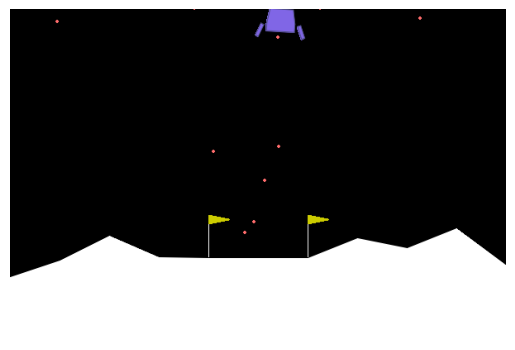

In [ ]:
utils.show_environment(ENV_ID)

In [19]:
vec_env = make_vec_env(ENV_ID, n_envs=4, monitor_dir=LOGS_PATH)

In [ ]:
utils.describe_environment(vec_env)

Observation Space:
  Box(shape=(8,), dtype=float32, low=-10.0, high=10.0)
  Example observation: [ 0.41224033  1.3086056   8.883539   -9.431838   -2.6359231  -4.824621
  0.32064357  0.11574553]

Action Space:
  Discrete(n=4)
  Example action: 1

Max episode steps: 1000


### Model

TODO Describe the parameters below

TODO Run on GPU?

In [31]:
model = PPO(
    policy = 'MlpPolicy',
    env = vec_env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

Using cpu device


In [32]:
model.learn(total_timesteps=LEARN_STEPS)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 88.4     |
|    ep_rew_mean     | -191     |
| time/              |          |
|    fps             | 7579     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.1        |
|    ep_rew_mean          | -176        |
| time/                   |             |
|    fps                  | 6531        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.003505719 |
|    clip_fraction        | 0.0123      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.00133     |
|    learning_rate        | 0.

In [33]:
# Save the trained model
model.save(MODEL_PATH)

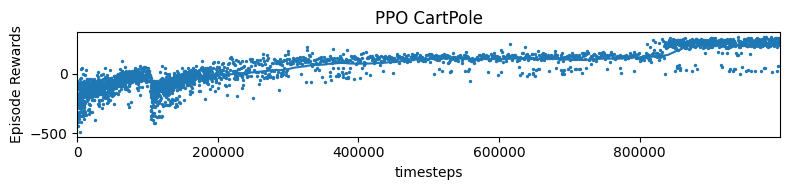

In [34]:
# Plot results using Stable-Baselines3 helper
plot_results([LOGS_PATH], LEARN_STEPS, results_plotter.X_TIMESTEPS, "PPO CartPole")
plt.show()

### Evaluate

In [ ]:
# Load the saved model
model = PPO.load(MODEL_PATH, device="cpu")

In [37]:
metrics = utils.evaluate_model(model, ENV_ID)
print(metrics)

{'mean_reward': np.float64(264.91025240000005), 'std_reward': np.float64(19.753393285229603), 'n_eval_episodes': 10}


In [50]:
utils.record_agent_video(model, ENV_ID, video_path=VIDEO_PATH, steps=1000)

Saved video to videos/LunarLander_PPO.mp4


In [51]:
Video(VIDEO_PATH, embed=True)